## Assignment 5
### Morgana Iacocca

### 0. Imports

In [1]:
import numpy as np
from numpy import random
from astropy.io import ascii
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import WMAP3 as cosmo
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'sans-serif'})
from astropy.io import fits
import math
import scipy.special as sc
import scipy.integrate as integrate
import fsps

# animation
from matplotlib.animation import FuncAnimation
from IPython import display
from matplotlib import animation, rc
from IPython.display import HTML, Image
rc('animation', html='html5')

# Rotations
from scipy.spatial.transform import Rotation as R


In [2]:
def getAcceleration(pos, mass, G, softening):
    # Calculate acceleration on each particle
    
    # pos : N x 3 numpy array of positions, [r1, r2, r3, ..., rN]
    #     where rN = [xN, yN, zN]
    # mass : N x 1 numpy array of masses, [m1, m2, ..., mN]
    # G is gravitational constant
    # softening is softening length, protects from numerical issues of point masses
    #
    # returns a: N x 3 numpy array of accelerations [a1, a2, a3, ..., aN]
    #     where aN = [aXN, aYN, aZN]
    
    x = pos[:,0:1] # Get column vector of x positions, 1 x N numpy array
    y = pos[:,1:2] # Get column vector of y positions, 1 x N numpy array
    z = pos[:,2:3] # get column vector of z positions, 1 x N numpy array

    
    # Subtracts each column vector from its transpose to get an
    #    N x N numpy array of separation values
    
    dX = x.T - x
    dY = y.T - y
    dZ = z.T - z
    
    r = np.sqrt(dX**2 + dY**2 + dZ**2)
    
    # Calculates r^{-3} using elementwise numpy matrix operations
    inv_rCubed = (dX**2 + dY**2 + dZ**2 + softening**2)**(-1.5)
    inv_rCubed[np.where(r < softening)] = 0
    
    # matrix multiplies (x_i / r^{-3}) by mass numpy matrix
    aX = G * (dX * inv_rCubed) @ mass
    aY = G * (dY * inv_rCubed) @ mass
    aZ = G * (dZ * inv_rCubed) @ mass
    
    # pack together the components, to create an N x 3 acceleration matrix
    #    a = [[ax1, ay2, az1]
    #         [ax2, ay2, az2],
    #         . . .
    #         [axN, ayN, azN]]
    
    a = np.hstack((aX, aY, aZ))
    
    return a

In [3]:
# For sanity checks at the end

def getEnergy(pos, vel, mass, G):
    # Calculates the kinetic, potential, and total energy of the system
    
    # pos : N x 3 numpy array of positions, [r1, r2, r3, ..., rN]
    #     where rN = [xN, yN, zN]
    # mass : N x 1 numpy array of masses, [m1, m2, ..., mN]
    # G is gravitational constant
    # softening is softening length, protects from numerical issues of point masses
    #
    # returns KE, PE, TE
    
    x = pos[:,0:1] # Get column vector of x positions, 1 x N numpy array
    y = pos[:,1:2] # Get column vector of y positions, 1 x N numpy array
    z = pos[:,2:3] # get column vector of z positions, 1 x N numpy array

    
    # Subtracts each column vector from its transpose to get an
    #    N x N numpy array of separation values
    
    dX = x.T - x
    dY = y.T - y
    dZ = z.T - z
    
    # Calculates r^{-1} using elementwise numpy matrix operations
    inv_r = np.sqrt(dX**2 + dY**2 + dZ**2)
    inv_r[inv_r>0] = 1.0/(inv_r[inv_r>0])
    
    PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))
    
    KE = 0.5 * np.sum(np.sum(mass*(vel**2)))
    
    TE = KE + PE
    
    return KE, PE, TE

In [4]:
def make3DSimulationAnimation(N, t, tEnd, dt, softening, G, mass, pos, vel, fname):
    # Convert to Center-of-Mass frame
    vel -= np.mean(mass * vel,0) / np.mean(mass)

    # calculate initial gravitational accelerations
    acc = getAcceleration( pos, mass, G, softening )

    # calculate initial energy of system
    KE, PE, TE  = getEnergy( pos, vel, mass, G )

    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # save energies, particle orbits for plotting trails
    pos_save = np.zeros((N,3,Nt+1))
    pos_save[:,:,0] = pos
    KE_save = np.zeros(Nt+1)
    KE_save[0] = KE
    PE_save = np.zeros(Nt+1)
    PE_save[0] = PE
    t_all = np.arange(Nt+1)*dt

    for i in range(Nt):
        vel += acc * dt/2.0

        # drift
        pos += vel * dt

        # updateAccelerations
        acc = getAcceleration(pos, mass, G, softening)

        # 2nd half kick
        vel += acc * dt/2.0

        # Step forward in time
        t += dt

        # get energy of system
        KE, PE, TE  = getEnergy( pos, vel, mass, G )

        # save energies, positions for plotting trail
        pos_save[:,:,i+1] = pos
        KE_save[i+1] = KE
        PE_save[i+1] = PE

    # prep figure
    fig = plt.figure(figsize=(7,7), dpi=200)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax = fig.add_subplot(projection='3d')

    xx = pos_save[:,0,0]        
    yy = pos_save[:,1,0]
    zz = pos_save[:,2,0]
    x = pos_save[:,0,0]
    y = pos_save[:,1,0]
    z = pos_save[:,2,0]

    myTrailScatter = ax.scatter(xx,yy,zz,s=1,color=[.7,.7,1], alpha=0.5)
    myCurrentScatter = ax.scatter(x,y,z, s=10,color='blue')

    def animationSimulate3DFunction(frame):  
        #plt.sca(ax1)
        #plt.cla()

        xx = pos_save[:,0,max(frame-30,0):frame+1]
        tempXX = xx[0]
        for i in range(1, len(xx)):
            tempXX = np.concatenate((tempXX, xx[i]))

        yy = pos_save[:,1,max(frame-30,0):frame+1]
        tempYY = yy[0]
        for i in range(1, len(yy)):
            tempYY = np.concatenate((tempYY, yy[i]))

        zz = pos_save[:,2,max(frame-30,0):frame+1]
        tempZZ = zz[0]
        for i in range(1, len(zz)):
            tempZZ = np.concatenate((tempZZ, zz[i]))

        x = pos_save[:,0,frame+1]
        y = pos_save[:,1,frame+1]
        z = pos_save[:,2,frame+1]
        myTrailScatter._offsets3d = (tempXX, tempYY, tempZZ)
        myCurrentScatter._offsets3d = (x,y,z)

    animationCreated = FuncAnimation(fig, animationSimulate3DFunction, frames=Nt, interval=25)
    animationCreated

    animationCreated.save(fname)

In [5]:
def make2DSimulationAnimation(N, t, tEnd, dt, softening, G, mass, pos, vel, fname):
    # Convert to Center-of-Mass frame
    vel -= np.mean(mass * vel,0) / np.mean(mass)

    # calculate initial gravitational accelerations
    acc = getAcceleration( pos, mass, G, softening )

    # calculate initial energy of system
    KE, PE, TE  = getEnergy( pos, vel, mass, G )

    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # save energies, particle orbits for plotting trails
    pos_save = np.zeros((N,3,Nt+1))
    pos_save[:,:,0] = pos
    KE_save = np.zeros(Nt+1)
    KE_save[0] = KE
    PE_save = np.zeros(Nt+1)
    PE_save[0] = PE
    t_all = np.arange(Nt+1)*dt

    for i in range(Nt):
        vel += acc * dt/2.0

        # drift
        pos += vel * dt

        # updateAccelerations
        acc = getAcceleration(pos, mass, G, softening)

        # 2nd half kick
        vel += acc * dt/2.0

        # Step forward in time
        t += dt

        # get energy of system
        KE, PE, TE  = getEnergy( pos, vel, mass, G )

        # save energies, positions for plotting trail
        pos_save[:,:,i+1] = pos
        KE_save[i+1] = KE
        PE_save[i+1] = PE

    # prep figure
    fig = plt.figure(figsize=(7,7), dpi=200)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)

    xx = pos_save[:,0,0]        
    yy = pos_save[:,1,0]
    x = pos_save[:,0,0]
    y = pos_save[:,1,0]

    myTrailScatter = plt.scatter(xx,yy,s=5,color=[.7,.7,1], alpha=0.5)
    myCurrentScatter = plt.scatter(x,y, s=50,color='blue')

    def animationSimulate2DFunction(frame):  
        #plt.sca(ax1)
        #plt.cla()

        xx = pos_save[:,0,max(frame-30,0):frame+1]
        tempXX = xx[0]
        for i in range(1, len(xx)):
            tempXX = np.concatenate((tempXX, xx[i]))

        yy = pos_save[:,1,max(frame-30,0):frame+1]
        tempYY = yy[0]
        for i in range(1, len(yy)):
            tempYY = np.concatenate((tempYY, yy[i]))

        x = pos_save[:,0,frame+1]
        y = pos_save[:,1,frame+1]
        myTrailScatter.set_offsets(np.column_stack((tempXX, tempYY)))
        myCurrentScatter.set_offsets(np.column_stack((x, y)))

    animationCreated = FuncAnimation(fig, animationSimulate2DFunction, frames=Nt, interval=25)
    animationCreated

    animationCreated.save(fname)
    plt.clf()
    plt.close()
    plt.scatter(t_all, KE_save, color='red',s=1,label='KE')
    plt.scatter(t_all, PE_save, color='blue',s=1,label='PE')
    plt.scatter(t_all, PE_save+KE_save, color='black',s=1,label='TE')
    plt.show()

Shows that N-Body works, don't run unless u wanna wait for the animation to build :/

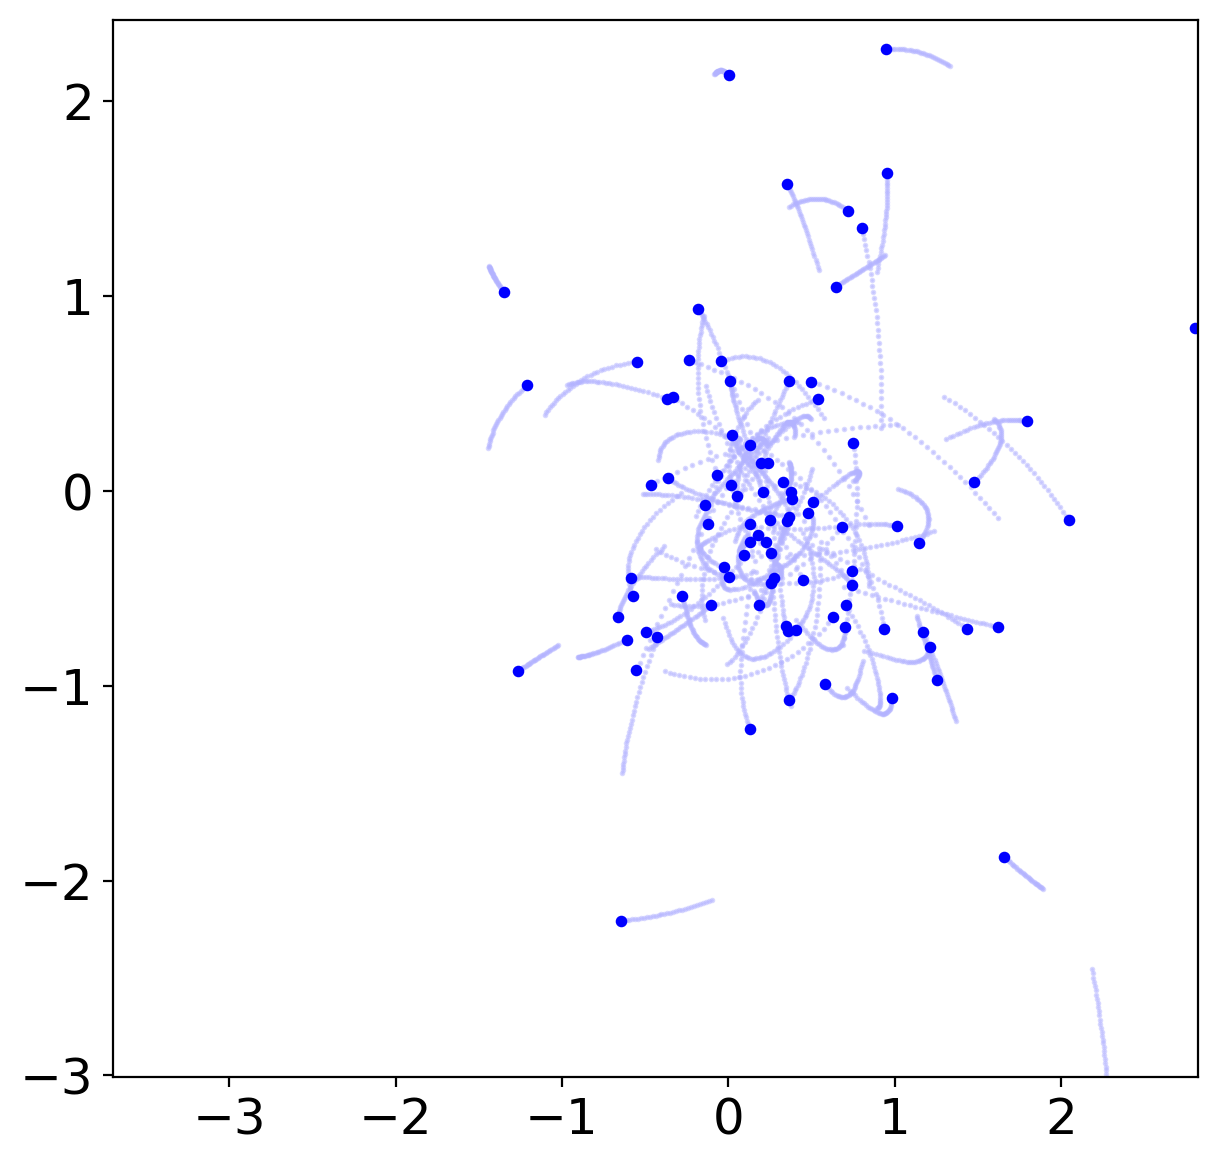

In [84]:
N         = 100    # Number of particles
t         = 0      # current time of the simulation
tEnd      = 10.0   # time at which simulation ends
dt        = 0.01   # timestep
softening = 0.1    # softening length
G         = 1.0    # Newton's Gravitational Constant

# Generate Initial Conditions :
np.random.seed(17)            # set the random number generator seed

mass = 20.0*np.ones((N,1))/N  # total mass of particles is 20

pos  = np.random.randn(N,3)   # randomly selected positions and velocities
vel  = np.random.randn(N,3)
fname = "testFunctionCall2D.mp4"
make2DSimulationAnimation(N, t, tEnd, dt, softening, G, mass, pos, vel, fname)

C:\Users\morga\anaconda3\envs\myenv\lib\site-packages\scipy\spatial\transform\rotation.py:1967: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  warnings.warn("Optimal rotation is not uniquely or poorly defined "


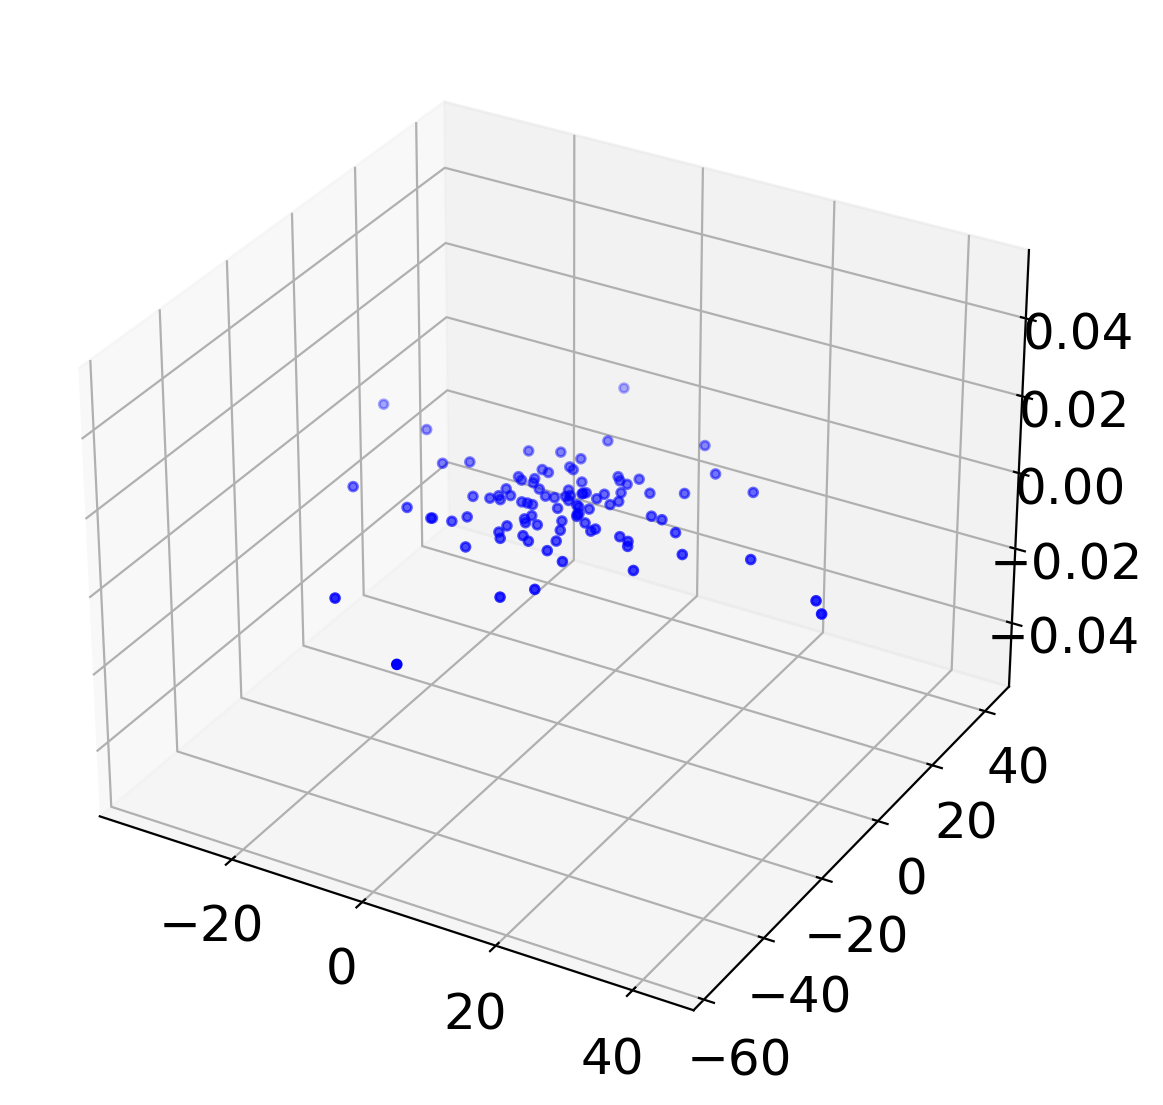

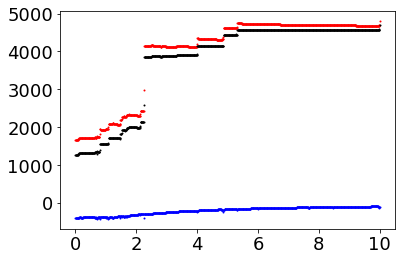

In [94]:
def make2DGalaxy(center, normalVector, bulgeRadius, haloRadius, thinDiskScaleLength, thinDiskScaleHeight, thickDiskScaleLength, thickDiskScaleHeight, bulgeFrac, haloFrac, thinFrac, thickFrac, G, num):
    holeMass = 100
    
    nBulge = math.ceil(float(num)*bulgeFrac)
    nHalo = math.ceil(float(num)*haloFrac)
    nThin = math.ceil(float(num)*thinFrac)
    nThick = math.ceil(float(num)*thickFrac)
    # Assume spherical bulge and halo
    
    # Assume circular isotropy throughout all parts
    
    
    
    vecA = [[0, 0, 1]] # build circle on X-Y plane before rotate

    rotMat = R.align_vectors([normalVector], vecA)
    
    restFrameCart = []
    restFramePolar = []
    
    # Build Bulge
    '''for i in range(nBulge):
        r = random.uniform(0, bulgeRadius)
        #phi = random.uniform(0, 2*math.pi)
        theta = random.uniform(0, 2*math.pi)
        restFramePolar.append([r, theta, 0])
        restFrameCart.append([r*math.cos(theta), r*math.sin(theta), 0])'''
    
    # Add a black hole at the center
    restFrameCart.append([0,0,0])
    restFramePolar.append([0,0,0])
    
        
    # Build Halo
    for i in range(nHalo):
        good = False
        while(not good):
            r = random.uniform(0, haloRadius)
            if(r > bulgeRadius):
                good = True
        #phi = random.uniform(0, 2*math.pi)
        theta = random.uniform(0, 2*math.pi)
        restFramePolar.append([r, theta, 0])
        restFrameCart.append([r*math.cos(theta), r*math.sin(theta), 0])
    
    # Build Thin Disk
    for i in range(nThin):
        good = False
        while(not good):
            r = random.exponential(scale = thinDiskScaleLength)
            if(r > bulgeRadius):
                good = True
        theta = random.uniform(0, 2*math.pi)
        restFramePolar.append([r, theta, 0])
        restFrameCart.append([r*math.cos(theta), r*math.sin(theta), 0])
        
    # Build Thick Disk
    for i in range(nThick):
        good = False
        while(not good):
            r = random.exponential(scale = thickDiskScaleLength)
            if(r > bulgeRadius):
                good = True
        theta = random.uniform(0, 2*math.pi)
        restFramePolar.append([r, theta, 0])
        restFrameCart.append([r*math.cos(theta), r*math.sin(theta), 0])
    
    # Get the velocities using Interior mass
    restFrameVelocities = []
    tempPolar = np.array(restFramePolar)
    for i in range(len(restFramePolar)):
        r = tempPolar[i][0]
        if(r < bulgeRadius):
            vMag = 0
        else:    
            enclosedMass = holeMass
            vMag = np.sqrt(G*enclosedMass/(r+.01))
        restFrameVelocities.append([-1.0*vMag*math.sin(restFramePolar[i][1]), vMag*math.cos(restFramePolar[i][1]), 0])
    
    # Build Masses
    masses = np.ones((len(restFrameCart), 1))
    #masses[0] = holeMass
    
    rotatedFramePositions = []
    rotatedFrameVelocities = []
        
    for i in range(len(restFrameCart)):
        tempRotated = rotMat[0].apply(restFrameCart[i])        
        rotatedFramePositions.append([center[0] + tempRotated[0], center[1] + tempRotated[1], center[2] + tempRotated[2]])
        rotVel = rotMat[0].apply(restFrameVelocities[i])
        rotatedFrameVelocities.append(rotMat[0].apply(restFrameVelocities[i]))
        
    return np.array(rotatedFramePositions), np.array(rotatedFrameVelocities), np.array(masses)

N         = 100    # Number of particles
t         = 0      # current time of the simulation
tEnd      = 10.0   # time at which simulation ends
dt        = 0.01   # timestep
softening = 0.2    # softening length
G         = 1    # Newton's Gravitational Constant

testVec = [0, 0, 1]
N = 100
myPositions, myVelocities, myMasses = make2DGalaxy([0, 0, 0], testVec, 3.0, 10.0, 10.0, 1, 8.0, 1, .049, .01, .85, .1, G, N)
realN = len(myPositions)

fig = plt.figure(figsize=(7,7), dpi=200)
grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
ax = fig.add_subplot(projection='3d')

ax.scatter(myPositions[:,0],myPositions[:,1],myPositions[:,2], s=10,color='blue')    
plt.show()
mySoftening = 0.01
make2DSimulationAnimation(realN, t, tEnd, dt, mySoftening, G, myMasses, myPositions, myVelocities, "DiskTest.mp4")

C:\Users\morga\anaconda3\envs\myenv\lib\site-packages\scipy\spatial\transform\rotation.py:1967: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  warnings.warn("Optimal rotation is not uniquely or poorly defined "


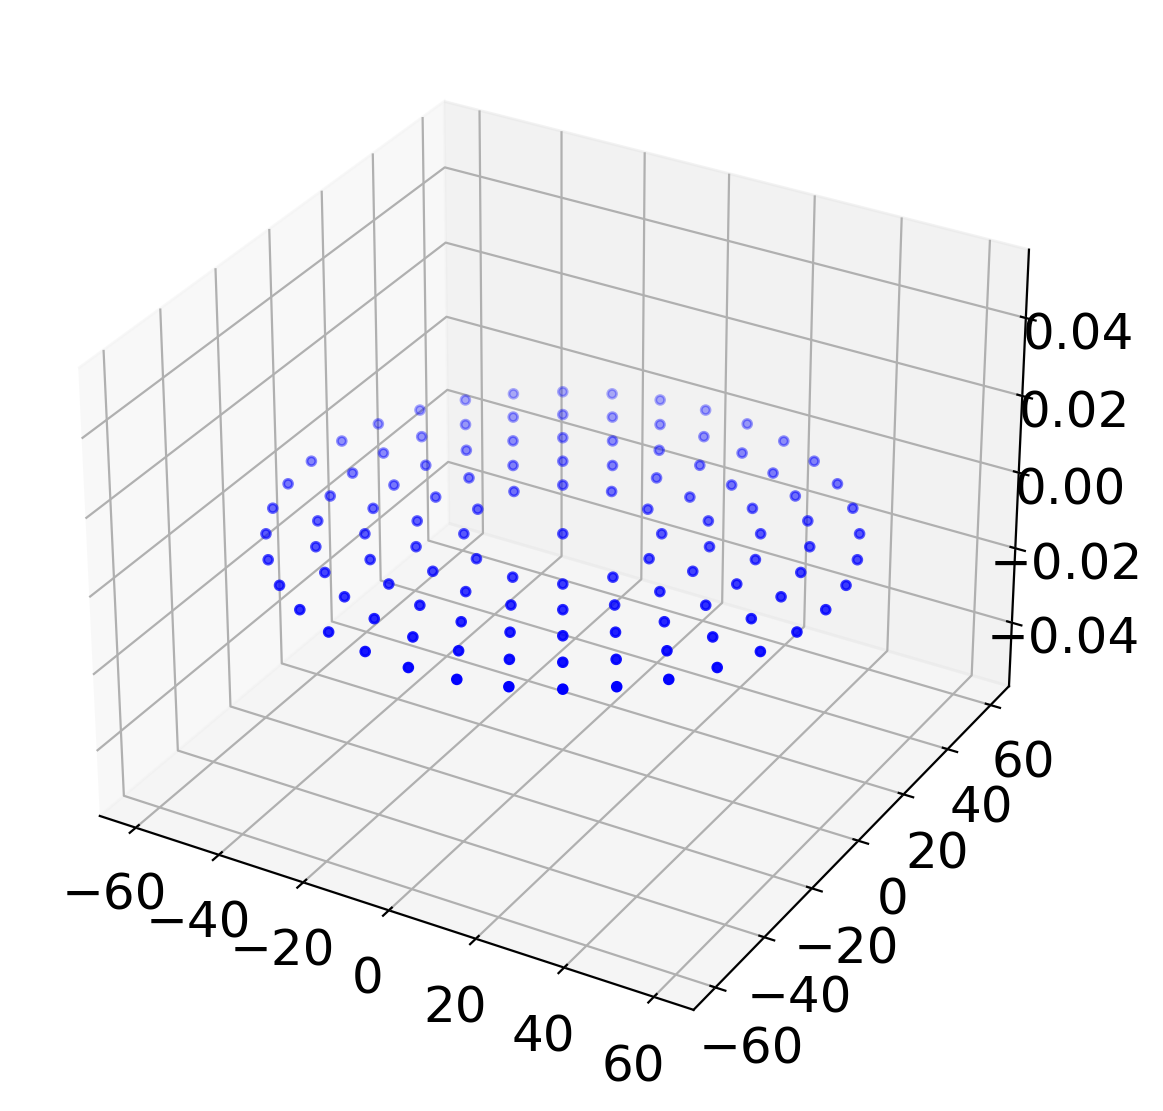

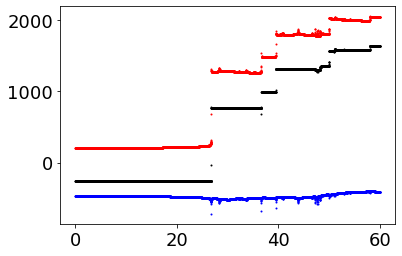

In [6]:
def makeSimpleGalaxy(center, normalVector, r1, r2, r3, r4, r5, n1, n2, n3, n4, n5, G):
    
    holeMass = 100.0
    
    # Assume circular isotropy throughout all parts
    
    vecA = [[0, 0, 1]] # build circle on X-Y plane before rotate

    rotMat = R.align_vectors([normalVector], vecA)
    
    restFrameCart = []
    restFrameVelocities = []
    masses = np.ones((n1+n2+n3+n4+n5+1, 1))
    
    # Add a black hole at the center
    restFrameCart.append([0,0,0])
    restFrameVelocities.append([0,0,0])
    masses[0] = holeMass
        
    # Build Ring 1
    dTheta = 2.0*math.pi/(n1)
    for i in range(n1):
        restFrameCart.append([r1*np.cos(i*dTheta), r1*np.sin(i*dTheta),0])
        vMag = np.sqrt(G*holeMass/r1)
        restFrameVelocities.append([-1.0*vMag*np.sin(i*dTheta), vMag*np.cos(i*dTheta), 0])
    
    # Build Ring 2
    dTheta = 2.0*math.pi/(n2)
    for i in range(n2):
        restFrameCart.append([r2*np.cos(i*dTheta), r2*np.sin(i*dTheta),0])
        vMag = np.sqrt(G*(holeMass+n1)/r2)
        restFrameVelocities.append([-1.0*vMag*np.sin(i*dTheta), vMag*np.cos(i*dTheta), 0])
        
    # Build Ring 3
    dTheta = 2.0*math.pi/(n3)
    for i in range(n3):
        restFrameCart.append([r3*np.cos(i*dTheta), r3*np.sin(i*dTheta),0])
        vMag = np.sqrt(G*(holeMass+n1+n2)/r3)
        restFrameVelocities.append([-1.0*vMag*np.sin(i*dTheta), vMag*np.cos(i*dTheta), 0])
    
    # Build Ring 4
    dTheta = 2.0*math.pi/(n4)
    for i in range(n4):
        restFrameCart.append([r4*np.cos(i*dTheta), r4*np.sin(i*dTheta),0])
        vMag = np.sqrt(G*(holeMass+n1+n2+n3)/r4)
        restFrameVelocities.append([-1.0*vMag*np.sin(i*dTheta), vMag*np.cos(i*dTheta), 0])
    
    # Build Ring 5
    dTheta = 2.0*math.pi/(n5)
    for i in range(n5):
        restFrameCart.append([r5*np.cos(i*dTheta), r5*np.sin(i*dTheta),0])
        vMag = np.sqrt(G*(holeMass+n1+n2+n3+n4)/r5)
        restFrameVelocities.append([-1.0*vMag*np.sin(i*dTheta), vMag*np.cos(i*dTheta), 0])
    
    rotatedFramePositions = []
    rotatedFrameVelocities = []
        
    for i in range(len(restFrameCart)):
        tempRotated = rotMat[0].apply(restFrameCart[i])        
        rotatedFramePositions.append([center[0] + tempRotated[0], center[1] + tempRotated[1], center[2] + tempRotated[2]])
        rotVel = rotMat[0].apply(restFrameVelocities[i])
        rotatedFrameVelocities.append(rotMat[0].apply(restFrameVelocities[i]))
        
    return np.array(rotatedFramePositions), np.array(rotatedFrameVelocities), np.array(masses)

N         = 100    # Number of particles
t         = 0      # current time of the simulation
tEnd      = 60.0   # time at which simulation ends
dt        = 0.01   # timestep
softening = 0.2    # softening length
G         = 1    # Newton's Gravitational Constant

testVec = [0, 0, 1]
myPositions, myVelocities, myMasses = makeSimpleGalaxy([0, 0, 0], testVec, 20, 30, 40, 50, 60, 12, 18, 24, 30, 36, G)
realN = len(myPositions)

fig = plt.figure(figsize=(7,7), dpi=200)
grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
ax = fig.add_subplot(projection='3d')

ax.scatter(myPositions[:,0],myPositions[:,1],myPositions[:,2], s=10,color='blue')    
plt.show()
mySoftening = 0.01
make2DSimulationAnimation(realN, t, tEnd, dt, mySoftening, G, myMasses, myPositions, myVelocities, "galaxyOfOfTwoRingsTest.mp4")

In [255]:
class Galaxy2D:
    def __init__(self, galpos, galvel, galmass, G):
        self.galpos = galpos
        self.galvel = galvel
        self.galmass = galmass
        
        self.galacc = np.zeros((3,))
        
        self.starpos = np.zeros((0,0))
        self.starvel = np.zeros((0,0))        
        self.staracc = np.zeros((0,0))
        
        self.G = G
    
    def initializeStars(self, normalVector, num):
        G = self.G

        vecA = [[0, 0, 1]] # build circle on X-Y plane before rotate

        rotMat = R.align_vectors([normalVector], vecA)

        restFrameCart = []
        restFramePolar = []
        restFrameVelocities = []
        
        for i in range(num):
            r = random.uniform(1, 20)
            theta = random.uniform(0, 2*math.pi)
            vMag = np.array(np.sqrt(self.galmass/r))
            restFrameCart.append([r*math.cos(theta)+self.galpos[0], r*math.sin(theta)+self.galpos[1], 0+self.galpos[2]])
            restFrameVelocities.append([-1.0*vMag*math.sin(theta)+self.galvel[0], vMag*math.cos(theta)+self.galvel[1], 0+self.galvel[2]])
        
        self.starpos = np.array(restFrameCart)
        self.starvel = np.array(restFrameVelocities)
        self.staracc = np.zeros((len(self.starpos), 1))

        '''for i in range(len(restFrameCart)):
            tempRotated = rotMat[0].apply(restFrameCart[i])        
            rotatedFramePositions.append([self.galpos[0] + tempRotated[0], self.galpos[1] + tempRotated[1], self.galpos[2] + tempRotated[2]])
            rotVel = rotMat[0].apply(restFrameVelocities[i])
            rotatedFrameVelocities.append(rotMat[0].apply(restFrameVelocities[i]))

        self.starpos = np.array([[1,0,0], [-1, 0, 0]])
        self.starvel = np.array([[0,np.sqrt(100),0], [0,-1*np.sqrt(100),0]])
        self.staracc = np.zeros((len(self.starpos), 1))'''
    
    def getAccelerationDueToGalCenter(self, otherPositions):
        G = self.G
        dpos = otherPositions - self.galpos # only the galaxy center acts gravitationally on any masses
        calculatedAcceleration = []
        for dpo in dpos:
            r = np.sqrt(dpo[0]**2 + dpo[1]**2 + dpo[2]**2)
            if(r > 0.1):
                accelMag = -1*G*self.galmass/(r**3)
            else:
                accelMag = 0
            calculatedAcceleration.append(accelMag*dpo)
        
        return np.array(calculatedAcceleration)
    
    def halfKickGal(self, dtime):
        temp = self.galvel + (self.galacc*dtime/2.0)
        self.galvel = temp
        
    def driftGal(self, dtime):
        temp = self.galpos + (self.galvel*dtime)
        self.galpos = temp
    
    def halfKickStar(self, dtime):
        temp = self.starvel + (self.staracc*dtime/2.0)
        self.starvel = temp
        
    def driftStar(self, dtime):
        temp = self.starpos + (self.starvel*dtime)
        self.starpos = temp

In [180]:
def make2DSimulationAnimationGalaxies(t, tEnd, dt, galaxy1, galaxy2, fname):

    # calculate initial gravitational accelerations
    galaxy1.galacc = galaxy2.getAccelerationDueToGalCenter(galaxy1.galpos)
    galaxy2.galacc = galaxy1.getAccelerationDueToGalCenter(galaxy2.galpos)
    
    commonacc = ((galaxy1.galmass*galaxy1.galacc) + (galaxy2.galmass*galaxy2.galacc))/(galaxy1.galmass+galaxy2.galmass)
    galaxy1.galacc = galaxy1.galacc - commonacc
    galaxy2.galacc = galaxy2.galacc - commonacc
    
    if(len(galaxy1.starpos) > 0):
        galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)
    
    if(len(galaxy2.starpos) > 0):
        galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)

    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # save energies, particle orbits for plotting trails
    if(len(galaxy1.starpos) > 0):
        if(len(galaxy2.starpos) > 0):
            pos = np.concatenate(([galaxy1.galpos], [galaxy2.galpos], galaxy1.starpos, galaxy2.starpos))
        else:
            pos = np.concatenate(([galaxy1.galpos], [galaxy2.galpos], galaxy1.starpos))
    else:
        pos = np.concatenate(([galaxy1.galpos], [galaxy2.galpos]))
    pos_save = np.zeros((len(pos),3,Nt+1))
    pos_save[:,:,0] = pos

    t_all = np.arange(Nt+1)*dt

    for i in range(Nt):
        # 1st half kick
        galaxy1.halfKickGal(dt)
        galaxy2.halfKickGal(dt)
        galaxy1.halfKickStar(dt)
        galaxy2.halfKickStar(dt)

        # drift
        galaxy1.driftGal(dt)
        galaxy2.driftGal(dt)
        galaxy1.driftStar(dt)
        galaxy2.driftStar(dt)

        # updateAccelerations
        galaxy1.galacc = galaxy2.getAccelerationDueToGalCenter(galaxy1.galpos)
        galaxy2.galacc = galaxy1.getAccelerationDueToGalCenter(galaxy2.galpos)

        commonacc = ((galaxy1.galmass*galaxy1.galacc) + (galaxy2.galmass*galaxy2.galacc))/(galaxy1.galmass+galaxy2.galmass)
        galaxy1.galacc = galaxy1.galacc - commonacc
        galaxy2.galacc = galaxy2.galacc - commonacc

        if(len(galaxy1.starpos) > 0):
            galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)

        if(len(galaxy2.starpos) > 0):
            galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)

        # 2nd half kick
        galaxy1.halfKickGal(dt)
        galaxy2.halfKickGal(dt)
        galaxy1.halfKickStar(dt)
        galaxy2.halfKickStar(dt)

        # Step forward in time
        t += dt
        
        # Save to POS Save
        if(len(galaxy1.starpos) > 0):
            if(len(galaxy2.starpos) > 0):
                pos = np.concatenate(([galaxy1.galpos], [galaxy2.galpos], galaxy1.starpos, galaxy2.starpos))
            else:
                pos = np.concatenate(([galaxy1.galpos], [galaxy2.galpos], galaxy1.starpos))
        else:
            pos = np.concatenate(([galaxy1.galpos], [galaxy2.galpos]))
        pos_save[:,:,i+1] = pos

    # prep figure
    fig = plt.figure(figsize=(7,7), dpi=200)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)

    xx = pos_save[:,0,0]        
    yy = pos_save[:,1,0]
    x = pos_save[:,0,0]
    y = pos_save[:,1,0]

    myTrailScatter = plt.scatter(xx,yy,s=5,color=[.7,.7,1], alpha=0.5)
    myCurrentScatter = plt.scatter(x,y, s=50,color='blue')

    def animationSimulate2DGalaxiesFunction(frame):  
        #plt.sca(ax1)
        #plt.cla()

        xx = pos_save[:,0,max(frame-30,0):frame+1]
        tempXX = xx[0]
        for i in range(1, len(xx)):
            tempXX = np.concatenate((tempXX, xx[i]))

        yy = pos_save[:,1,max(frame-30,0):frame+1]
        tempYY = yy[0]
        for i in range(1, len(yy)):
            tempYY = np.concatenate((tempYY, yy[i]))

        x = pos_save[:,0,frame+1]
        y = pos_save[:,1,frame+1]
        myTrailScatter.set_offsets(np.column_stack((tempXX, tempYY)))
        myCurrentScatter.set_offsets(np.column_stack((x, y)))

    animationCreated = FuncAnimation(fig, animationSimulate2DGalaxiesFunction, frames=Nt, interval=25)
    animationCreated

    animationCreated.save(fname)

In [244]:
testGalaxy1 = Galaxy2D(np.array([0,0,0]), np.array([0,0,0]), 100, 1)
testVec = [0,0,1]
N = 10
testGalaxy1.initializeStars(testVec, 3.0, 10.0, 10.0, 1, 8.0, 1, .049, .01, .85, .1, N)

testGalaxy2 = Galaxy2D(np.array([0, 0, 0]), np.array([0,0,0]), 0, 1)


t         = 0      # current time of the simulation
tEnd      = 10.0   # time at which simulation ends
dt        = 0.01   # timestep

make2DSimulationAnimationGalaxies(t, tEnd, dt, testGalaxy1, testGalaxy2, "pleasefuckingwork.mp4")

C:\Users\morga\anaconda3\envs\myenv\lib\site-packages\scipy\spatial\transform\rotation.py:1967: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  warnings.warn("Optimal rotation is not uniquely or poorly defined "


IndexError: invalid index to scalar variable.

In [285]:
def makesimpler2DSimulationAnimationGalaxies(t, tEnd, dt, galaxy1, galaxy2, fname):

    if(len(galaxy1.starpos) > 0):
        galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)
    
    if(len(galaxy2.starpos) > 0):
        galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)
    
    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # save energies, particle orbits for plotting trails
    pos = np.concatenate((galaxy1.starpos, np.array([galaxy1.galpos]), np.array([galaxy2.galpos])))
    pos_save = np.zeros((len(pos),3,Nt+1))
    pos_save[:,:,0] = pos

    t_all = np.arange(Nt+1)*dt

    for i in range(Nt):
        # 1st half kick

        galaxy2.halfKickGal(dt)
        galaxy1.halfKickGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.halfKickStar(dt)
            
        if(len(galaxy2.starpos) > 0):
            galaxy2.halfKickStar(dt)


        # drift
        galaxy1.driftGal(dt)
        galaxy2.driftGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.driftStar(dt)

        if(len(galaxy2.starpos) > 0):
            galaxy2.driftStar(dt)
        
        # updateAccelerations

        if(len(galaxy1.starpos) > 0):
            galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)

        if(len(galaxy2.starpos) > 0):
            galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)
        
        # 2nd half kick

        galaxy2.halfKickGal(dt)
        galaxy1.halfKickGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.halfKickStar(dt)
            
        if(len(galaxy2.starpos) > 0):
            galaxy2.halfKickStar(dt)

        # Step forward in time
        t += dt
        # Save to POS Save

        pos = np.concatenate((galaxy1.starpos, np.array([galaxy1.galpos]), np.array([galaxy2.galpos])))
        #print(pos)
        pos_save[:,:,i+1] = pos

    # prep figure
    fig = plt.figure(figsize=(7,7), dpi=200)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)

    xx = pos_save[:,0,0]        
    yy = pos_save[:,1,0]
    x = pos_save[:,0,0]
    y = pos_save[:,1,0]

    myTrailScatter = plt.scatter(xx,yy,s=5,color=[.7,.7,1], alpha=0.5)
    plt.ylim((-50,50))
    plt.xlim((-30,80))
    myCurrentScatter = plt.scatter(x,y, s=50,color='blue')

    def animationSimulateSimple2DGalaxiesFunction(frame):  
        #plt.sca(ax1)
        #plt.cla()

        xx = pos_save[:,0,max(frame-30,0):frame+1]
        tempXX = xx[0]
        for i in range(1, len(xx)):
            tempXX = np.concatenate((tempXX, xx[i]))

        yy = pos_save[:,1,max(frame-30,0):frame+1]
        tempYY = yy[0]
        for i in range(1, len(yy)):
            tempYY = np.concatenate((tempYY, yy[i]))

        x = pos_save[:,0,frame+1]
        y = pos_save[:,1,frame+1]
        myTrailScatter.set_offsets(np.column_stack((tempXX, tempYY)))
        myCurrentScatter.set_offsets(np.column_stack((x, y)))

    animationCreated = FuncAnimation(fig, animationSimulateSimple2DGalaxiesFunction, frames=Nt, interval=25)
    animationCreated

    animationCreated.save(fname)

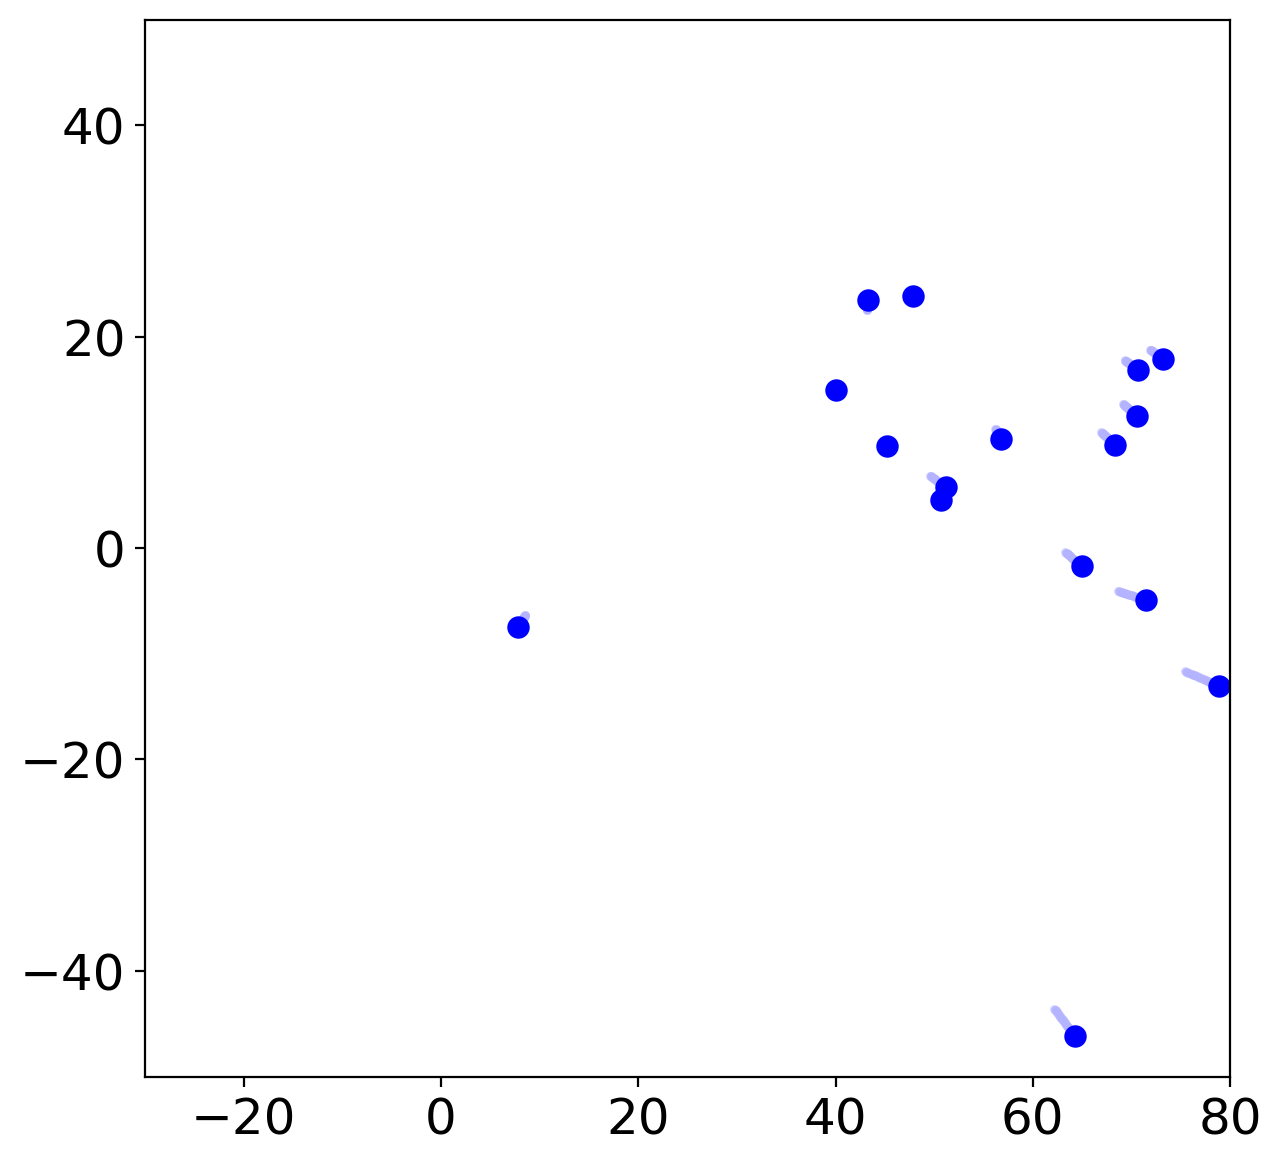

In [286]:
testGalaxy1 = Galaxy2D(np.array([0,0,0]), np.array([10,0,0]), 1000, 1)
testVec = [0,0,1]
N = 100
testGalaxy1.initializeStars(testVec, N)

testGalaxy2 = Galaxy2D(np.array([40,15,0]), np.array([0,0,0]), 100, 1)
#testGalaxy2.initializeStars(testVec, N)



t         = 0      # current time of the simulation
tEnd      = 10.0   # time at which simulation ends
dt        = 0.01   # timestep

makesimpler2DSimulationAnimationGalaxies(t, tEnd, dt, testGalaxy1, testGalaxy2, "movingDoubleGalNoStars.mp4")

In [346]:
class Galaxy3D:
    def __init__(self, galpos, galvel, galmass, G):
        self.galpos = galpos
        self.galvel = galvel
        self.galmass = galmass
        
        self.galacc = np.zeros((3,))
        
        self.starpos = np.zeros((0,0))
        self.starvel = np.zeros((0,0))        
        self.staracc = np.zeros((0,0))
        
        self.G = G
    
    def initializeStars(self, normalVector, num):
        G = self.G

        vecA = [[0, 0, 1]] # build circle on X-Y plane before rotate

        rotMat = R.align_vectors([normalVector], vecA)

        restFrameCart = []

        restFrameVelocities = []
        
        for i in range(num):
            r = random.uniform(1, 20)
            theta = random.uniform(0, 2*math.pi)
            vMag = np.array(np.sqrt(self.galmass/r))
            restFrameCart.append([r*math.cos(theta), r*math.sin(theta), 0])
            restFrameVelocities.append([-1.0*vMag*math.sin(theta), vMag*math.cos(theta), 0])

        rotatedFramePositions = []
        rotatedFrameVelocities = []
        for i in range(len(restFrameCart)):
            tempRotated = rotMat[0].apply(restFrameCart[i])        
            rotatedFramePositions.append([self.galpos[0] + tempRotated[0], self.galpos[1] + tempRotated[1], self.galpos[2] + tempRotated[2]])
            rotVel = rotMat[0].apply(restFrameVelocities[i])
            rotatedFrameVelocities.append([self.galvel[0] + rotVel[0], self.galvel[1] + rotVel[1], self.galvel[2] + rotVel[2]])

        self.starpos = np.array(rotatedFramePositions)
        self.starvel = np.array(rotatedFrameVelocities)
        self.staracc = np.zeros((len(self.starpos), 1))
    
    def getAccelerationDueToGalCenter(self, otherPositions):
        G = self.G
        dpos = otherPositions - self.galpos # only the galaxy center acts gravitationally on any masses
        print(dpos)
        calculatedAcceleration = []
        for dpo in dpos:
            r = np.sqrt(dpo[0]**2 + dpo[1]**2 + dpo[2]**2)
            if(r > 0.1):
                accelMag = -1*G*self.galmass/(r**3)
            else:
                accelMag = 0
            calculatedAcceleration.append(accelMag*dpo)
        
        return np.array(calculatedAcceleration)
    
    def halfKickGal(self, dtime):
        temp = self.galvel + (self.galacc*dtime/2.0)
        self.galvel = temp
        
    def driftGal(self, dtime):
        temp = self.galpos + (self.galvel*dtime)
        self.galpos = temp
    
    def halfKickStar(self, dtime):
        temp = self.starvel + (self.staracc*dtime/2.0)
        self.starvel = temp
        
    def driftStar(self, dtime):
        temp = self.starpos + (self.starvel*dtime)
        self.starpos = temp

In [297]:
def makesimpler3DSimulationAnimationGalaxies(t, tEnd, dt, galaxy1, galaxy2, fname):

    if(len(galaxy1.starpos) > 0):
        galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)
    
    if(len(galaxy2.starpos) > 0):
        galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)
    
    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # save energies, particle orbits for plotting trails
    pos = np.concatenate((galaxy1.starpos, np.array([galaxy1.galpos]), galaxy2.starpos, np.array([galaxy2.galpos])))
    pos_save = np.zeros((len(pos),3,Nt+1))
    pos_save[:,:,0] = pos

    t_all = np.arange(Nt+1)*dt

    for i in range(Nt):
        # 1st half kick

        galaxy2.halfKickGal(dt)
        galaxy1.halfKickGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.halfKickStar(dt)
            
        if(len(galaxy2.starpos) > 0):
            galaxy2.halfKickStar(dt)


        # drift
        galaxy1.driftGal(dt)
        galaxy2.driftGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.driftStar(dt)

        if(len(galaxy2.starpos) > 0):
            galaxy2.driftStar(dt)
        
        # updateAccelerations

        if(len(galaxy1.starpos) > 0):
            galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)

        if(len(galaxy2.starpos) > 0):
            galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)
        
        # 2nd half kick

        galaxy2.halfKickGal(dt)
        galaxy1.halfKickGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.halfKickStar(dt)
            
        if(len(galaxy2.starpos) > 0):
            galaxy2.halfKickStar(dt)

        # Step forward in time
        t += dt
        # Save to POS Save

        pos = np.concatenate((galaxy1.starpos, np.array([galaxy1.galpos]), galaxy2.starpos, np.array([galaxy2.galpos])))
        #print(pos)
        pos_save[:,:,i+1] = pos

    # prep figure
    fig = plt.figure(figsize=(7,7), dpi=200)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax = fig.add_subplot(projection='3d')

    xx = pos_save[:,0,0]        
    yy = pos_save[:,1,0]
    zz = pos_save[:,2,0]
    x = pos_save[:,0,0]
    y = pos_save[:,1,0]
    z = pos_save[:,2,0]

    #myTrailScatter = ax.scatter(xx,yy,zz,s=1,color=[.7,.7,1], alpha=0.5)
    myCurrentScatter = ax.scatter(x,y,z, s=10,color='blue')

    def animationSimulate3DFunction(frame):  
        #plt.sca(ax1)
        #plt.cla()

        xx = pos_save[:,0,max(frame-30,0):frame+1]
        tempXX = xx[0]
        for i in range(1, len(xx)):
            tempXX = np.concatenate((tempXX, xx[i]))

        yy = pos_save[:,1,max(frame-30,0):frame+1]
        tempYY = yy[0]
        for i in range(1, len(yy)):
            tempYY = np.concatenate((tempYY, yy[i]))

        zz = pos_save[:,2,max(frame-30,0):frame+1]
        tempZZ = zz[0]
        for i in range(1, len(zz)):
            tempZZ = np.concatenate((tempZZ, zz[i]))

        x = pos_save[:,0,frame+1]
        y = pos_save[:,1,frame+1]
        z = pos_save[:,2,frame+1]
        #myTrailScatter._offsets3d = (tempXX, tempYY, tempZZ)
        myCurrentScatter._offsets3d = (x,y,z)

    animationCreated = FuncAnimation(fig, animationSimulate3DFunction, frames=Nt, interval=25)
    animationCreated

    animationCreated.save(fname)

C:\Users\morga\anaconda3\envs\myenv\lib\site-packages\scipy\spatial\transform\rotation.py:1967: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  warnings.warn("Optimal rotation is not uniquely or poorly defined "


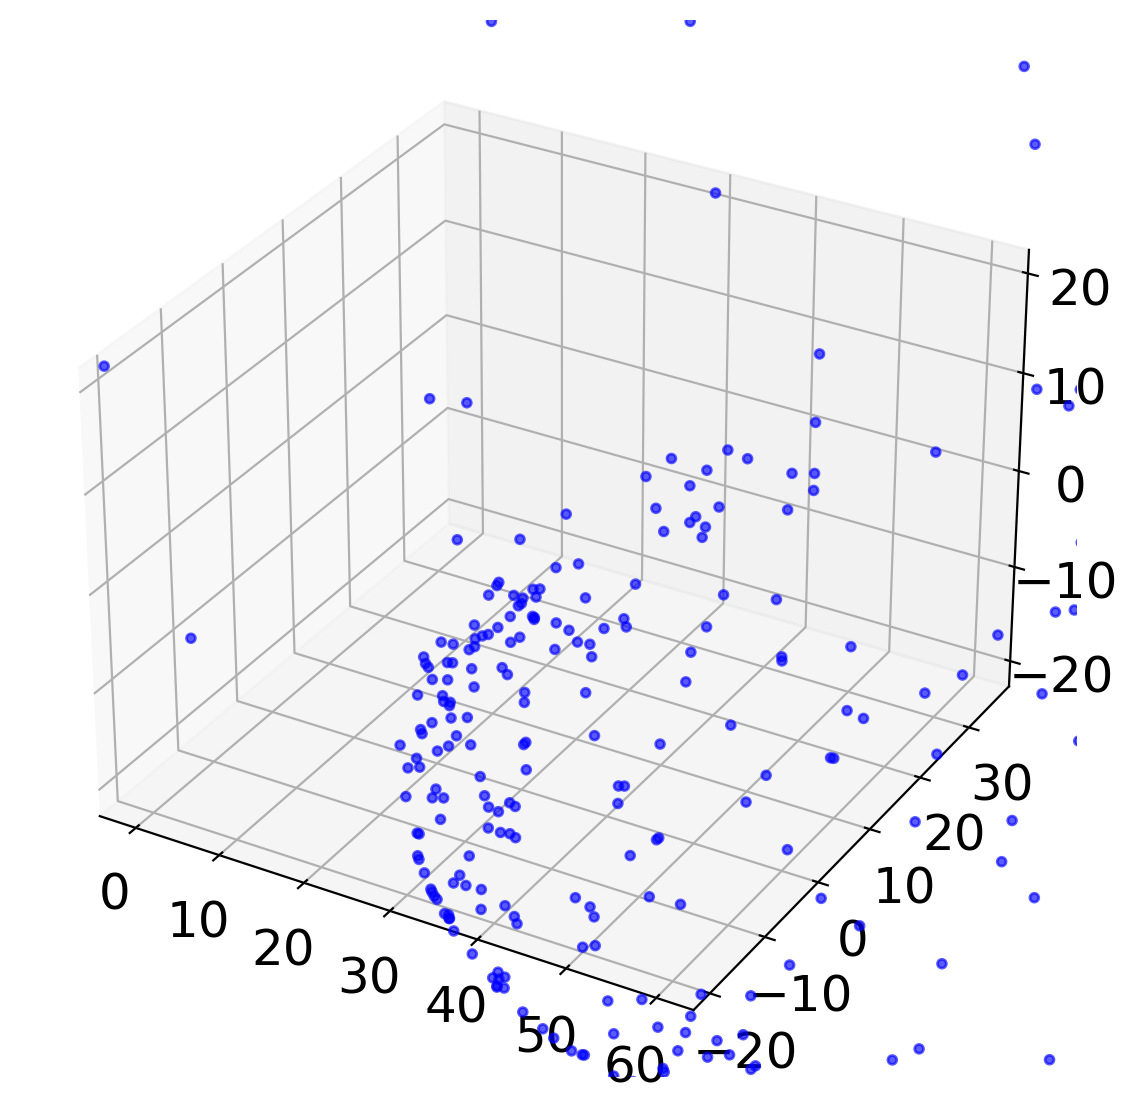

In [301]:
testGalaxy1 = Galaxy3D(np.array([0,0,0]), np.array([10,0,0]), 1000, 1)
testVec = [1,0,0]
N = 500
testGalaxy1.initializeStars(testVec, N)
testVec2 = [0,0,1]
testGalaxy2 = Galaxy3D(np.array([40,15,0]), np.array([0,0,0]), 100, 1)
testGalaxy2.initializeStars(testVec2, N)



t         = 0      # current time of the simulation
tEnd      = 10.0   # time at which simulation ends
dt        = 0.01   # timestep

makesimpler3DSimulationAnimationGalaxies(t, tEnd, dt, testGalaxy1, testGalaxy2, "movingDoubleGalYesStarsBiggerN3DNoTrailAngled2.mp4")

In [359]:
class Galaxy3DRings:
    def __init__(self, galpos, galvel, galmass, G):
        self.galpos = galpos
        self.galvel = galvel
        self.galmass = galmass
        
        self.galacc = np.zeros((3,))
        
        self.starpos = np.zeros((0,0))
        self.starvel = np.zeros((0,0))        
        self.staracc = np.zeros((0,0))
        
        self.G = G
    
    def initializeStars(self, normalVector):
        G = self.G

        vecA = [[0, 0, 1]] # build circle on X-Y plane before rotate

        rotMat = R.align_vectors([normalVector], vecA)

        restFrameCart = []

        restFrameVelocities = []
        
        r = 4
        dtheta = 2*math.pi/12
        for i in range(12):
            vMag = np.array(np.sqrt(self.galmass/r))
            restFrameCart.append([r*math.cos(i*dtheta), r*math.sin(i*dtheta), 0])
            restFrameVelocities.append([-1.0*vMag*math.sin(i*dtheta), vMag*math.cos(i*dtheta), 0])
            
        r = 6
        dtheta = 2*math.pi/18
        for i in range(18):
            vMag = np.array(np.sqrt(self.galmass/r))
            restFrameCart.append([r*math.cos(i*dtheta), r*math.sin(i*dtheta), 0])
            restFrameVelocities.append([-1.0*vMag*math.sin(i*dtheta), vMag*math.cos(i*dtheta), 0])
            
        r = 8
        dtheta = 2*math.pi/24
        for i in range(24):
            vMag = np.array(np.sqrt(self.galmass/r))
            restFrameCart.append([r*math.cos(i*dtheta), r*math.sin(i*dtheta), 0])
            restFrameVelocities.append([-1.0*vMag*math.sin(i*dtheta), vMag*math.cos(i*dtheta), 0])
            
        r = 10
        dtheta = 2*math.pi/30
        for i in range(30):
            vMag = np.array(np.sqrt(self.galmass/r))
            restFrameCart.append([r*math.cos(i*dtheta), r*math.sin(i*dtheta), 0])
            restFrameVelocities.append([-1.0*vMag*math.sin(i*dtheta), vMag*math.cos(i*dtheta), 0])
        
        r = 12
        dtheta = 2*math.pi/36
        for i in range(36):
            vMag = np.array(np.sqrt(self.galmass/r))
            restFrameCart.append([r*math.cos(i*dtheta), r*math.sin(i*dtheta), 0])
            restFrameVelocities.append([-1.0*vMag*math.sin(i*dtheta), vMag*math.cos(i*dtheta), 0])

        rotatedFramePositions = []
        rotatedFrameVelocities = []
        for i in range(len(restFrameCart)):
            tempRotated = rotMat[0].apply(restFrameCart[i])        
            rotatedFramePositions.append([self.galpos[0] + tempRotated[0], self.galpos[1] + tempRotated[1], self.galpos[2] + tempRotated[2]])
            rotVel = rotMat[0].apply(restFrameVelocities[i])
            rotatedFrameVelocities.append([self.galvel[0] + rotVel[0], self.galvel[1] + rotVel[1], self.galvel[2] + rotVel[2]])

        self.starpos = np.array(rotatedFramePositions)
        self.starvel = np.array(rotatedFrameVelocities)
        self.staracc = np.zeros((len(self.starpos), 1))
    
    def getAccelerationDueToGalCenter(self, otherPositions):
        G = self.G
        dpos = otherPositions - self.galpos # only the galaxy center acts gravitationally on any masses
        calculatedAcceleration = []
        for dpo in dpos:
            r = np.sqrt(dpo[0]**2 + dpo[1]**2 + dpo[2]**2)
            if(r > 0.5):
                accelMag = -1*G*self.galmass/(r**3)
            else:
                accelMag = 0
            calculatedAcceleration.append(accelMag*dpo)
        
        return np.array(calculatedAcceleration)
    
    def halfKickGal(self, dtime):
        temp = self.galvel + (self.galacc*dtime/2.0)
        self.galvel = temp
        
    def driftGal(self, dtime):
        temp = self.galpos + (self.galvel*dtime)
        self.galpos = temp
    
    def halfKickStar(self, dtime):
        temp = self.starvel + (self.staracc*dtime/2.0)
        self.starvel = temp
        
    def driftStar(self, dtime):
        temp = self.starpos + (self.starvel*dtime)
        self.starpos = temp

In [328]:
def makesimpler3DSimulationAnimationGalaxiesRing(t, tEnd, dt, galaxy1, galaxy2, fname):

    if(len(galaxy1.starpos) > 0):
        galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)
    
    if(len(galaxy2.starpos) > 0):
        galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)
    
    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # save energies, particle orbits for plotting trails
    pos = np.concatenate((galaxy1.starpos, np.array([galaxy1.galpos]), galaxy2.starpos, np.array([galaxy2.galpos])))
    pos_save = np.zeros((len(pos),3,Nt+1))
    pos_save[:,:,0] = pos

    t_all = np.arange(Nt+1)*dt

    for i in range(Nt):
        # 1st half kick

        galaxy2.halfKickGal(dt)
        galaxy1.halfKickGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.halfKickStar(dt)
            
        if(len(galaxy2.starpos) > 0):
            galaxy2.halfKickStar(dt)


        # drift
        galaxy1.driftGal(dt)
        galaxy2.driftGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.driftStar(dt)

        if(len(galaxy2.starpos) > 0):
            galaxy2.driftStar(dt)
        
        # updateAccelerations

        if(len(galaxy1.starpos) > 0):
            galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)

        if(len(galaxy2.starpos) > 0):
            galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)
        
        # 2nd half kick

        galaxy2.halfKickGal(dt)
        galaxy1.halfKickGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.halfKickStar(dt)
            
        if(len(galaxy2.starpos) > 0):
            galaxy2.halfKickStar(dt)

        # Step forward in time
        t += dt
        # Save to POS Save

        pos = np.concatenate((galaxy1.starpos, np.array([galaxy1.galpos]), galaxy2.starpos, np.array([galaxy2.galpos])))
        #print(pos)
        pos_save[:,:,i+1] = pos

    # prep figure
    fig = plt.figure(figsize=(7,7), dpi=200)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax = fig.add_subplot(projection='3d')

    xx = pos_save[:,0,0]        
    yy = pos_save[:,1,0]
    zz = pos_save[:,2,0]
    x = pos_save[:,0,0]
    y = pos_save[:,1,0]
    z = pos_save[:,2,0]

    #myTrailScatter = ax.scatter(xx,yy,zz,s=1,color=[.7,.7,1], alpha=0.5)
    myCurrentScatter = ax.scatter(x,y,z, s=10,color='blue')

    def animationSimulate3DFunction(frame):  
        #plt.sca(ax1)
        #plt.cla()

        xx = pos_save[:,0,max(frame-30,0):frame+1]
        tempXX = xx[0]
        for i in range(1, len(xx)):
            tempXX = np.concatenate((tempXX, xx[i]))

        yy = pos_save[:,1,max(frame-30,0):frame+1]
        tempYY = yy[0]
        for i in range(1, len(yy)):
            tempYY = np.concatenate((tempYY, yy[i]))

        zz = pos_save[:,2,max(frame-30,0):frame+1]
        tempZZ = zz[0]
        for i in range(1, len(zz)):
            tempZZ = np.concatenate((tempZZ, zz[i]))

        x = pos_save[:,0,frame+1]
        y = pos_save[:,1,frame+1]
        z = pos_save[:,2,frame+1]
        #myTrailScatter._offsets3d = (tempXX, tempYY, tempZZ)
        myCurrentScatter._offsets3d = (x,y,z)

    animationCreated = FuncAnimation(fig, animationSimulate3DFunction, frames=Nt, interval=25)
    animationCreated

    animationCreated.save(fname)

In [357]:
def makesimpler2DSimulationAnimationGalaxiesRing(t, tEnd, dt, galaxy1, galaxy2, fname):

    galaxy1.galacc = galaxy2.getAccelerationDueToGalCenter(np.array([galaxy1.galpos]))
    galaxy2.galacc = galaxy1.getAccelerationDueToGalCenter(np.array([galaxy2.galpos]))
    
    commonacc = ((galaxy1.galmass*galaxy1.galacc) + (galaxy2.galmass*galaxy2.galacc))/(galaxy1.galmass+galaxy2.galmass)
    galaxy1.galacc = galaxy1.galacc - commonacc
    galaxy2.galacc = galaxy2.galacc - commonacc
    
    if(len(galaxy1.starpos) > 0):
        galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)
    
    if(len(galaxy2.starpos) > 0):
        galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)
    
    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # save energies, particle orbits for plotting trails
    pos = np.concatenate((galaxy1.starpos, np.array([galaxy1.galpos]), galaxy2.starpos, np.array([galaxy2.galpos])))
    pos_save = np.zeros((len(pos),3,Nt+1))
    pos_save[:,:,0] = pos

    t_all = np.arange(Nt+1)*dt

    for i in range(Nt):
        # 1st half kick

        galaxy2.halfKickGal(dt)
        galaxy1.halfKickGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.halfKickStar(dt)
            
        if(len(galaxy2.starpos) > 0):
            galaxy2.halfKickStar(dt)


        # drift
        galaxy1.driftGal(dt)
        galaxy2.driftGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.driftStar(dt)

        if(len(galaxy2.starpos) > 0):
            galaxy2.driftStar(dt)
        
        # updateAccelerations

        galaxy1.galacc = galaxy2.getAccelerationDueToGalCenter(galaxy1.galpos)
        galaxy2.galacc = galaxy1.getAccelerationDueToGalCenter(galaxy2.galpos)

        commonacc = ((galaxy1.galmass*galaxy1.galacc) + (galaxy2.galmass*galaxy2.galacc))/(galaxy1.galmass+galaxy2.galmass)
        galaxy1.galacc = galaxy1.galacc - commonacc
        galaxy2.galacc = galaxy2.galacc - commonacc
        
        if(len(galaxy1.starpos) > 0):
            galaxy1.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy1.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy1.starpos)

        if(len(galaxy2.starpos) > 0):
            galaxy2.staracc = galaxy1.getAccelerationDueToGalCenter(galaxy2.starpos) + galaxy2.getAccelerationDueToGalCenter(galaxy2.starpos)
        
        # 2nd half kick

        galaxy2.halfKickGal(dt)
        galaxy1.halfKickGal(dt)
        if(len(galaxy1.starpos) > 0):
            galaxy1.halfKickStar(dt)
            
        if(len(galaxy2.starpos) > 0):
            galaxy2.halfKickStar(dt)

        # Step forward in time
        t += dt
        # Save to POS Save

        pos = np.concatenate((galaxy1.starpos, galaxy1.galpos, galaxy2.starpos, galaxy2.galpos))
        #print(pos)
        pos_save[:,:,i+1] = pos

    # prep figure
    fig = plt.figure(figsize=(7,7), dpi=200)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)

    xx = pos_save[:,0,0]        
    yy = pos_save[:,1,0]
    x = pos_save[:,0,0]
    y = pos_save[:,1,0]

    #myTrailScatter = plt.scatter(xx,yy,s=5,color=[.7,.7,1], alpha=0.5)
    plt.ylim((-50,50))
    plt.xlim((-30,80))
    myCurrentScatter = plt.scatter(x,y, s=10,color='blue')

    def animationSimulateSimple2DGalaxiesFunction(frame):  
        #plt.sca(ax1)
        #plt.cla()

        xx = pos_save[:,0,max(frame-30,0):frame+1]
        tempXX = xx[0]
        for i in range(1, len(xx)):
            tempXX = np.concatenate((tempXX, xx[i]))

        yy = pos_save[:,1,max(frame-30,0):frame+1]
        tempYY = yy[0]
        for i in range(1, len(yy)):
            tempYY = np.concatenate((tempYY, yy[i]))

        x = pos_save[:,0,frame+1]
        y = pos_save[:,1,frame+1]
        #myTrailScatter.set_offsets(np.column_stack((tempXX, tempYY)))
        myCurrentScatter.set_offsets(np.column_stack((x, y)))

    animationCreated = FuncAnimation(fig, animationSimulateSimple2DGalaxiesFunction, frames=Nt, interval=25)
    animationCreated

    animationCreated.save(fname)

C:\Users\morga\anaconda3\envs\myenv\lib\site-packages\scipy\spatial\transform\rotation.py:1967: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  warnings.warn("Optimal rotation is not uniquely or poorly defined "


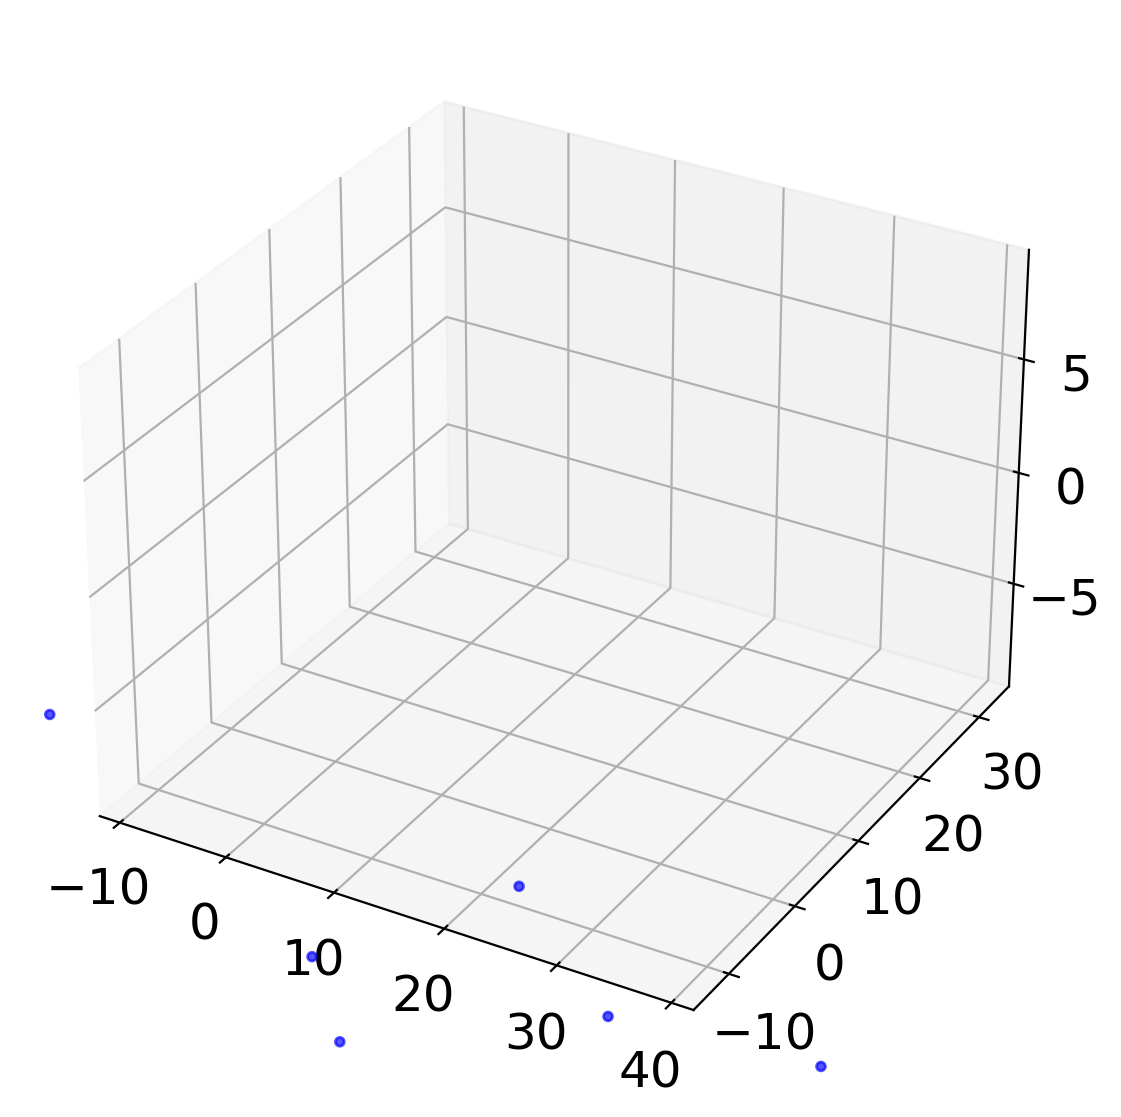

In [364]:
testGalaxy1 = Galaxy3DRings(np.array([0,0,0]), np.array([5,0,0]), 1000, 1)
testVec = [1,0,1]
testGalaxy1.initializeStars(testVec)
testVec2 = [-1,0,1]
testGalaxy2 = Galaxy3DRings(np.array([30,20,0]), np.array([-5,0,0]), 1000, 1)
testGalaxy2.initializeStars(testVec2)



t         = 0      # current time of the simulation
tEnd      = 20.0   # time at which simulation ends
dt        = 0.01   # timestep

makesimpler3DSimulationAnimationGalaxiesRing(t, tEnd, dt, testGalaxy1, testGalaxy2, "movingRingAngledYesStars3DstationaryMainNonAngledWithGalAcc3.mp4")